In [128]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pymap3d as pm
from scipy.spatial.transform import Rotation
import math
from pathlib import Path
from utils import project_root

In [129]:
plt.rcParams["figure.figsize"] = (20,10)

# Extrinsic calibrations and globals

In [130]:
r_b2i = Rotation.from_euler('z', 1.5708, degrees=False)
R_b2i = r_b2i.as_matrix()

In [131]:
R_b2i

array([[-3.6732051e-06, -1.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00, -3.6732051e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [132]:
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))

In [133]:
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]

In [134]:
rot_order = 'zxy'

In [135]:
grav = -9.80665

# Topic Covariance matrices

In [136]:
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]

In [137]:
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]

# Helper functions

In [138]:
def normalize(v, tolerance=1e-12):
    mag2 = sum(n * n for n in v)
    if mag2 > tolerance:
        mag = math.sqrt(mag2)
        v = tuple(n / mag for n in v)
    return np.array(v)

In [139]:
# as defined in Sola, page 6
def quat_mult(quaternion0, quaternion1):
    x0, y0, z0, w0 = quaternion0
    x1, y1, z1, w1 = quaternion1
    
    qw = w0*w1 - x0*x1 - y0*y1 - z0*z1
    qx = w0*x1 + x0*w1 + y0*z1 - z0*y1
    qy = w0*y1 - x0*z1 + y0*w1 + z0*x1
    qz = w0*z1 + x0*y1 - y0*x1 + z0*w1
    
    result = np.array([qx, qy, qz, qw]).reshape((4,1))

    return result

In [140]:
def euler2quat(x, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, x.flatten(), degrees=False)

    # Convert to quaternions and print
    rot_quat = rot.as_quat() # [x,y,z,w]
    
    return rot_quat.reshape((4,1))

In [141]:
def quat2euler(x, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(x.flatten())

    # Convert to quaternions and print
    rot_euler = rot.as_euler(axis, degrees=False) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# Load data

In [142]:
os.chdir(Path(project_root() / 'data/topics'))

## GPS data

### WGS84 (lattitude, longitude, altitude) - "/gps/fix"

In [143]:
lines = []
with open('gps.txt') as f:
    lines = f.readlines()

In [144]:
lattitude = []
longitude = []
altitude = []
sec_gps = []
nsec_gps = []
count = 0
for line in lines:
    count += 1
    if line[4:7] == "sec":
        sec_gps.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_gps.append(int(line[13:-1]))
    elif line[0:3] == "lat":
        lattitude.append(float(line[10:-1]))
    elif line[0:3] == "lon":
        longitude.append(float(line[11:-1]))
    elif line[0:3] == "alt":
        altitude.append(float(line[10:-1]))

In [145]:
temp = [i*1e-9 for i in nsec_gps]
t_gps = [sum(x) for x in zip(sec_gps, temp)]
tt_gps = np.array([x-t_gps[0] for x in t_gps])

### Positions (x_gps, y_gps, z_gps) - base_link frame

In [146]:
lat_0 = lattitude[0]
lon_0 = longitude[0]
alt_0 = altitude[0]

x_gps = []
y_gps = []
z_gps = []
for i in range(len(lattitude)):
    # get [east, noth up] w.r.t. an origin and assume it is [y, x, z]
    x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
    # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
    x_gps.append(x_ + x_off)
    y_gps.append(y_ + y_off)
    z_gps.append(z_ + z_off)

x_gps = np.array(x_gps)
y_gps = np.array(y_gps)
z_gps = np.array(z_gps)

In [147]:
gps_cov = [[0.019599999999999996, 0, 0],
           [0, 0.019599999999999996, 0],
           [0, 0, 0.31359999999999993]]

### Velocities

In [148]:
vx_gps = []
vy_gps = []
vz_gps = []
for i in range(len(tt_gps)):

    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        vx, vy, vz = 0, 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        vx = (x_gps[i] - x_gps[i-1])/dt
        vy = (y_gps[i] - y_gps[i-1])/dt
        vz = (z_gps[i] - z_gps[i-1])/dt
        
    vx_gps.append(vx)
    vy_gps.append(vy)
    vz_gps.append(vz)

vx_gps = np.array(vx_gps)
vy_gps = np.array(vy_gps)
vz_gps = np.array(vz_gps)

### Accelerations

In [149]:
ax_gps = []
ay_gps = []
az_gps = []
for i in range(len(tt_gps)):

    # in the first iteration, get x,y from gps and theta from imu
    if i==0:
        ax, ay, az = 0, 0, 0
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_gps[i] - tt_gps[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")

        # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
        ax = (vx_gps[i] - vx_gps[i-1])/dt
        ay = (vy_gps[i] - vy_gps[i-1])/dt
        az = (vz_gps[i] - vz_gps[i-1])/dt
        
    ax_gps.append(ax)
    ay_gps.append(ay)
    az_gps.append(az)

ax_gps = np.array(ax_gps)
ay_gps = np.array(ay_gps)
az_gps = np.array(az_gps)

### Plot positions when static to find variances

In [150]:
m = 30
t = np.arange(m)

[-0.0096609   0.01762649  2.13443333]


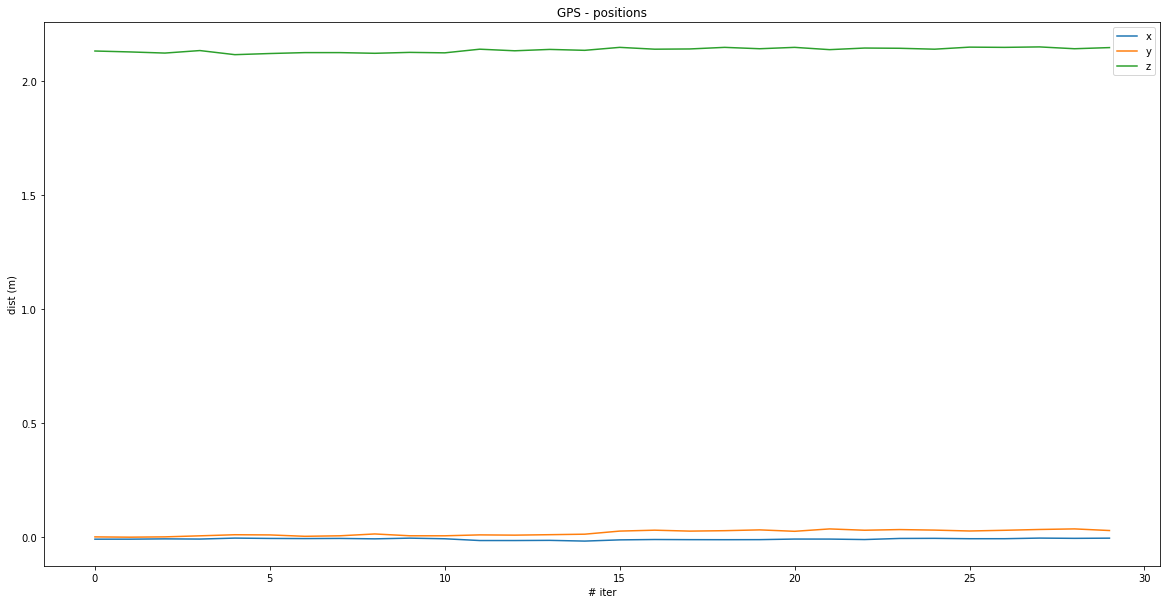

In [151]:
gps_bias = np.array([np.mean(x_gps[0:m]), np.mean(y_gps[0:m]), np.mean(z_gps[0:m])])
print(gps_bias)

plt.plot(t, x_gps[0:m], label="x")
plt.plot(t, y_gps[0:m], label="y")
plt.plot(t, z_gps[0:m], label="z")
plt.title("GPS - positions")
plt.ylabel("dist (m)")
plt.xlabel("# iter")
plt.legend()
plt.show()

In [152]:
v_x = np.var(x_gps[0:m])
v_y = np.var(y_gps[0:m])
v_z = np.var(z_gps[0:m])
print("Gps variances: ", v_x, v_y, v_z)
print("Gps std. deviations: ", np.sqrt(v_x), np.sqrt(v_y), np.sqrt(v_z))

Gps variances:  1.1960487593898167e-05 0.00014961380391449012 9.764555605550465e-05
Gps std. deviations:  0.0034583937881476376 0.012231672163465228 0.009881576597664194


### Plot positions over the entire dataset

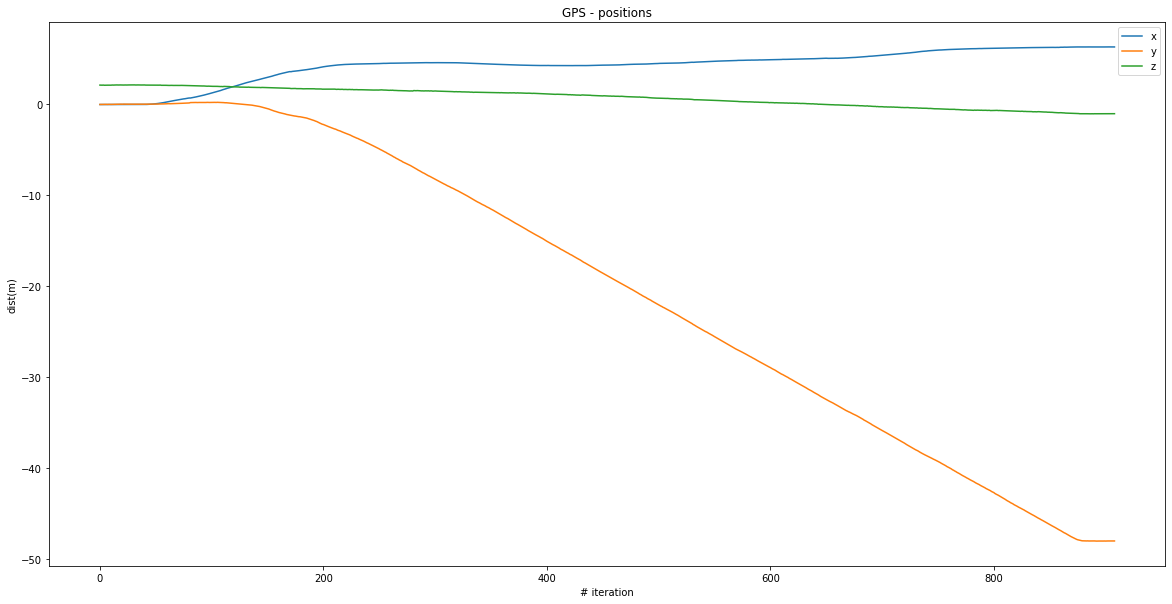

In [153]:
plt.plot(x_gps, label="x")
plt.plot(y_gps, label="y")
plt.plot(z_gps, label="z")
plt.title("GPS - positions")
plt.ylabel("dist(m)")
plt.xlabel("# iteration")
plt.legend()
plt.show()

## IMU data (orientation, ang_vel, lin_acc) - "/ouster/imu"

### Load IMU data

In [154]:
lines = []
with open('imu.txt') as f:
    lines = f.readlines()

In [155]:
ang_vel = [] # [w_x, w_y, w_z]
ang_vel_e = []
lin_acc = [] # [x_ddot, y_ddot, z_ddot]
sec_imu = []
nsec_imu = []
count = 0

# to convert the offset from base_link to quaternions
rot = Rotation.from_euler(rot_order, imu_rot_off, degrees=False)
imu_rot_quat_off = rot.as_quat()

for idx, line in enumerate(lines):
    count += 1
    if line[4:7] == "sec":
        sec_imu.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_imu.append(int(line[13:-1]))
    elif line[0:-1] == "orientation:":
        qx = float(lines[idx+1][5:-1])
        qy = float(lines[idx+2][5:-1])
        qz = float(lines[idx+3][5:-1])
        qw = float(lines[idx+4][5:-1])
        q = [qx, qy, qz, qw] + imu_rot_quat_off
    elif line[0:-1] == "angular_velocity:":
        w_x = float(lines[idx+1][5:-1])
        w_y = float(lines[idx+2][5:-1])
        w_z = float(lines[idx+3][5:-1])
        ang_vel.append([w_x, w_y, w_z])
        ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
    elif line[0:-1] == "linear_acceleration:":
        a_x = float(lines[idx+1][5:-1])
        a_y = float(lines[idx+2][5:-1])
        a_z = float(lines[idx+3][5:-1]) + grav
        lin_acc.append([a_x, a_y, a_z])

ang_vel = np.array(ang_vel)
ang_vel_e = np.array(ang_vel_e)
lin_acc = np.array(lin_acc)

In [156]:
temp = [i*1e-9 for i in nsec_imu]
t_imu = [sum(x) for x in zip(sec_imu, temp)]
tt_imu = [x-t_imu[0] for x in t_imu]

### Find IMU bias

In [157]:
m = 300
t = np.arange(m)

[-0.01907755  0.01299578 -0.00510084]


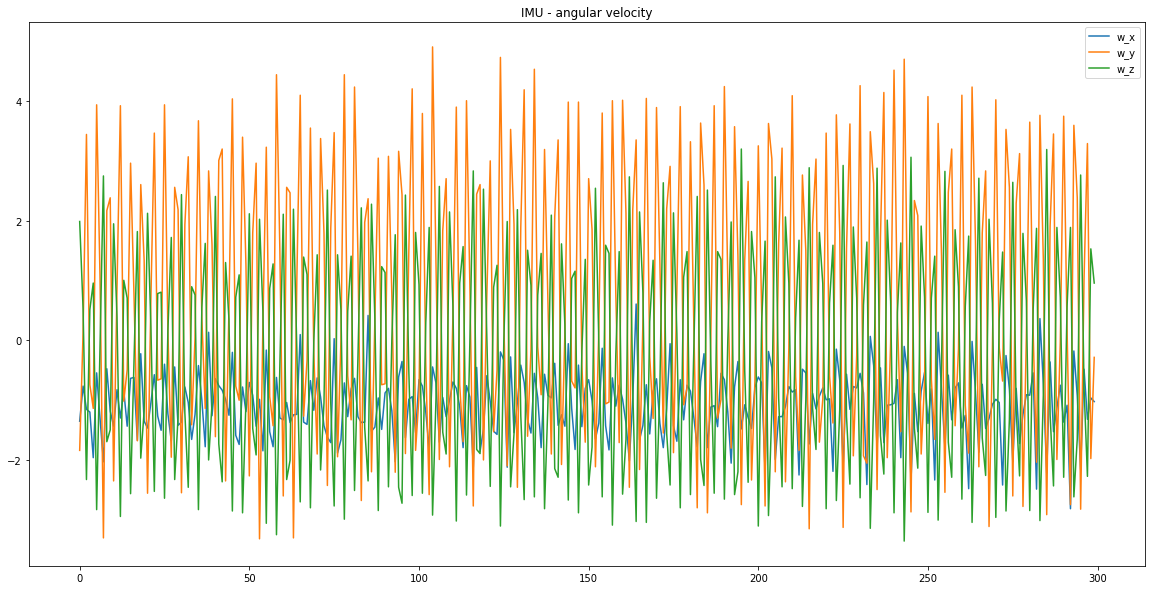

In [158]:
static_ang_vel = np.array(ang_vel)[0:m,:]
ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
print(ang_vel_imu_bias)

plt.plot(t, ang_vel_e[0:m,0], label="w_x")
plt.plot(t, ang_vel_e[0:m,1], label="w_y")
plt.plot(t, ang_vel_e[0:m,2], label="w_z")
plt.title("IMU - angular velocity")
plt.legend()
plt.show()

[ 0.10895214 -0.80556905 -0.09362127]


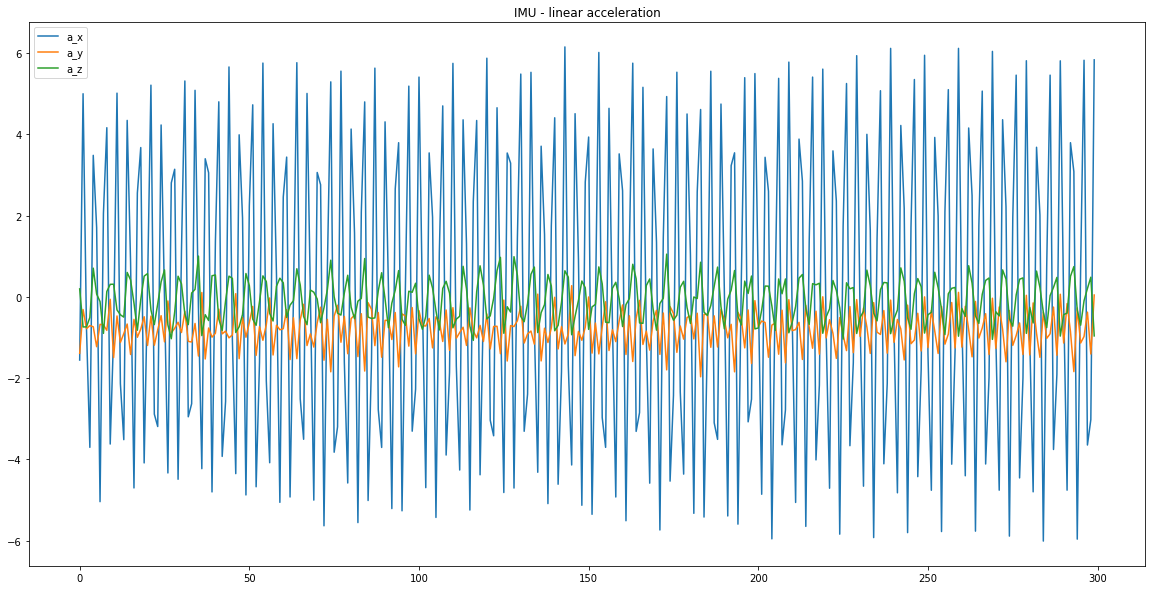

In [159]:
static_lin_acc = np.array(lin_acc)[0:m,:]
lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
lin_acc_imu_bias[2] = lin_acc_imu_bias[2] # remove gravity, as this is not a bias
print(lin_acc_imu_bias)

plt.plot(t, lin_acc[0:m,0], label="a_x")
plt.plot(t, lin_acc[0:m,1], label="a_y")
plt.plot(t, lin_acc[0:m,2], label="a_z")
plt.title("IMU - linear acceleration")
plt.legend()
plt.show()

### Plot IMU data (w. bias) for the entire dataset

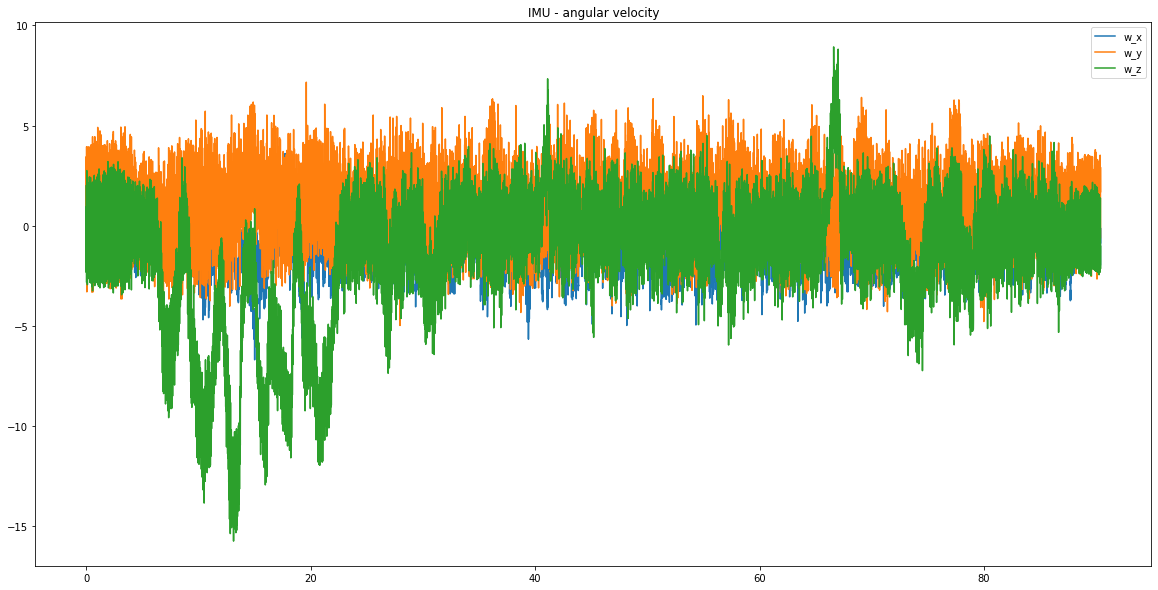

In [160]:

plt.plot(tt_imu, ang_vel_e[:,0], label="w_x")
plt.plot(tt_imu, ang_vel_e[:,1], label="w_y")
plt.plot(tt_imu, ang_vel_e[:,2], label="w_z")
plt.title("IMU - angular velocity")
plt.legend()
plt.show()

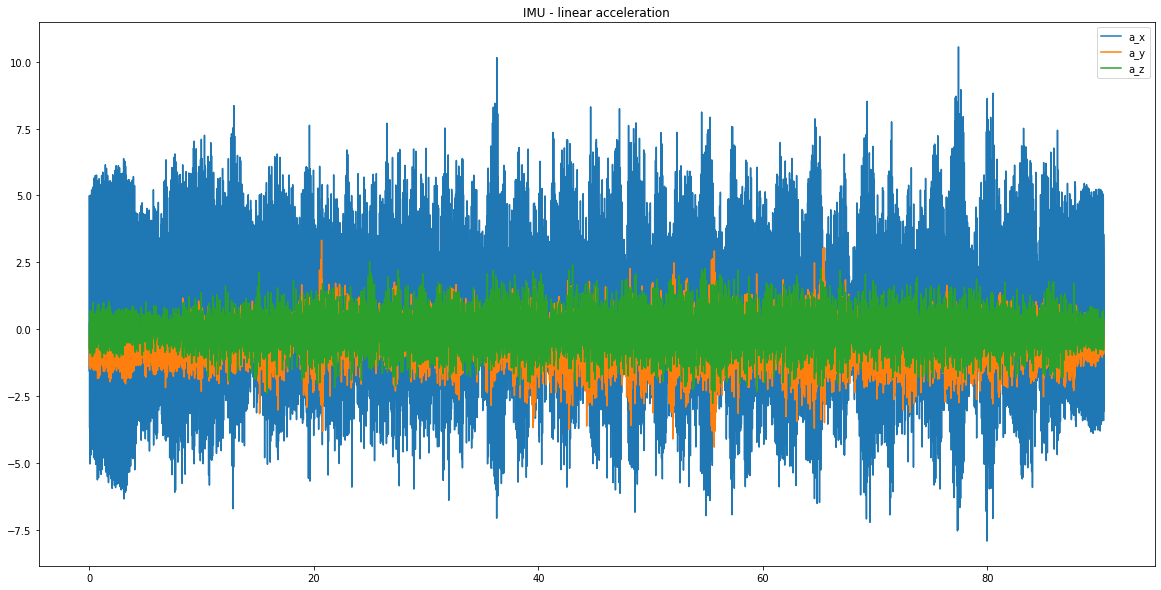

In [161]:
plt.plot(tt_imu, lin_acc[:,0], label="a_x")
plt.plot(tt_imu, lin_acc[:,1], label="a_y")
plt.plot(tt_imu, lin_acc[:,2], label="a_z")
plt.title("IMU - linear acceleration")
plt.legend()
plt.show()

### Extract orientation (based on initial orientation from manual tunning in radar odometry)

In [162]:
theta0_z = 0.3
theta_imu_list = []
theta_x_prev = 0
theta_y_prev = 0
theta_z_prev = 0
for i in range(len(tt_imu)):
    # in the first iteration, set theta = 0
    if i==0:
        theta_x = 0
        theta_y = 0
        theta_z = theta0_z
    # in the rest, get it from kinematics
    else:
        # get dt in seconds
        dt = tt_imu[i] - tt_imu[i-1]
        if dt<0:
            print(f"Error! Negative dt: {dt}")
            
        # get yaw rate from the IMU readings
        w_imu_x = ang_vel[i][0] - ang_vel_imu_bias[0]
        w_imu_y = ang_vel[i][1] - ang_vel_imu_bias[1]
        w_imu_z = ang_vel[i][2] - ang_vel_imu_bias[2]
            
        # assuming 0 angular acceleration
        theta_x = theta_x_prev + w_imu_x*dt
        theta_y = theta_y_prev + w_imu_y*dt
        theta_z = theta_z_prev + w_imu_z*dt
        
    theta_imu_list.append([theta_x, theta_y, theta_z])
        
    theta_x_prev = theta_x
    theta_y_prev = theta_y
    theta_z_prev = theta_z

theta_imu_list = np.array(theta_imu_list)

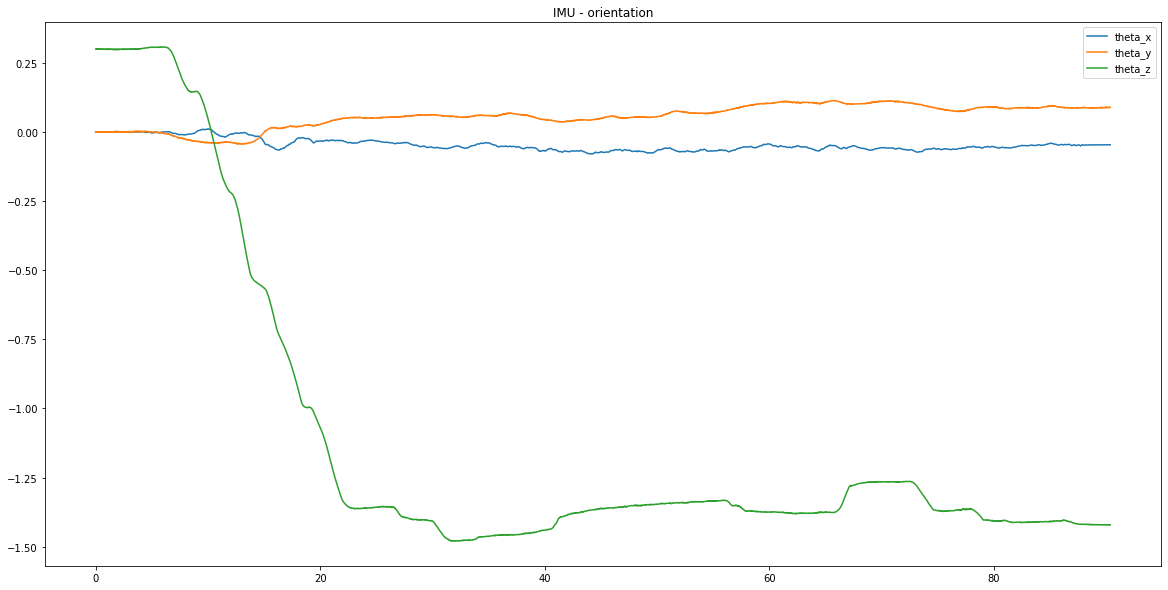

In [163]:
plt.plot(tt_imu, theta_imu_list[:,0], label="theta_x")
plt.plot(tt_imu, theta_imu_list[:,1], label="theta_y")
plt.plot(tt_imu, theta_imu_list[:,2], label="theta_z")
plt.title("IMU - orientation")
plt.legend()
plt.show()

## Radar data

In [164]:
lines = []
with open('radar_odom.txt') as f:
    lines = f.readlines()

In [165]:
v_radar = [] # velocity in the x axis
w_radar = [] # rotational velocity around z axis
sec_radar = []
nsec_radar = []
for line in lines:
    if line[4:7] == "sec":
        sec_radar.append(int(line[9:-1]))
    elif line[4:11] == "nanosec":
        nsec_radar.append(int(line[13:-1]))
    elif line[0:3] == "v_x":
        if line[5:-1] != ".nan":
            v = float(line[5:-1])
            if abs(v) < 10:
                v_radar.append(float(v))
    elif line[0:5] == "omega":
        if line[7:-1] != ".nan":
            omega = float(line[7:-1])
            w_radar.append(float(omega))

In [166]:
temp = [i*1e-9 for i in nsec_radar]
t_radar = [sum(x) for x in zip(sec_radar, temp)]
tt_radar = [x-t_radar[0] for x in t_radar]

In [167]:
w_radar_e = [np.rad2deg(i) for i in w_radar] #transform quaternion to euler

# IMU - GPS sensor fusion

Following "Error State Extended Kalman Filter Multi-Sensor Fusion for
Unmanned Aerial Vehicle Localization in GPS and Magnetometer
Denied Indoor Environments" by Lovro M. et al.

## Functions

### Nominal state - large signal : IMU

In [168]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:2]
    v_prev = x_prev[2:4]
    theta_prev = x_prev[4]
    a_b = x_prev[5:7]
    omega_b = x_prev[7]
    p_i = x_prev[8:11]
    theta_i = x_prev[11:14]
    
    # convert euler to quaternions
    q_prev = euler2quat(theta_prev, axis='z')
    q_temp = euler2quat((omega_imu - omega_b)*dt, axis='z')

    # find the current robot rotation matrix
    r_robot = Rotation.from_quat(q_prev.flatten())
    R_robot = r_robot.as_matrix()

    # extract the current Rotation (IMU frame rotation + robot rotation)
    R_nom = R_b2i*R_robot

    # apply dynamics to position, velocity and orientation
    a_ = np.vstack((a_imu-a_b, 0))
    Ra = np.matmul(R_nom, a_)[0:2]
    p = p_prev + v_prev*dt + 0.5*Ra*(dt**2)
    v = v_prev + Ra*dt
    q = quat_mult(q_prev, q_temp)
    q = normalize(q)

    # convert back to euler
    theta = quat2euler(q)[2]
    
    # the nominal state
    x_out = np.vstack((p, v, theta, a_b, omega_b, p_i, theta_i))
    
    return x_out

### Prediction ( Error state) : IMU

In [169]:
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt)

    dx = np.matmul(Fx, dx_prev) #+ np.matmul(Fw,w) # this is always zero!

    t1 = np.matmul(np.matmul(Fx, P_prev),
                   np.transpose(Fx))
    t2 = np.matmul(np.matmul(Fw, Qw), 
                   np.transpose(Fw))

    P = t1 + t2 # this is the only term we are interested in
    
    return dx, P

In [170]:
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    return np.array([[0, -x[2][0], x[1][0]],
                     [x[2][0], 0, -x[0][0]],
                     [-x[1][0], x[0][0], 0]]).reshape((3,3))

In [171]:
# calculate A (for F)
def get_A(dt, a_imu, a_b):
    a_ = a_imu - a_b
    a__ = np.vstack((a_, 0))
    return skew(a__)*dt

In [172]:
# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x_prev[5:7]
    omega_b = x_prev[7]

    A = get_A(dt, a_imu, a_b)
    omega = (omega_imu - omega_b)*dt
    omega = omega[0]
    r_omega = Rotation.from_euler('z', omega)
    Rw = r_omega.as_matrix()

    # find the current robot rotation matrix
    theta_ = x[4][0]
    r_robot = Rotation.from_euler('z', theta_)
    R_robot = r_robot.as_matrix()

    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i*R_robot
    
    # shortcuts to terms
    RA = np.matmul(R,A)
    RA_ = np.array([RA[0,2], RA[1,2]]).reshape((2,1))
    Rdt = R*dt
        
    Fx1 = np.hstack((I2, I2*dt, np.zeros((2,10))))
    Fx2 = np.hstack((O2, I2, -RA_, -Rdt[0:2,0:2].reshape(2,2), np.zeros((2,7))))
    Fx3 = np.array([0, 0, 0, 0, Rw.T[2,2], 0, 0, -dt, 0, 0, 0, 0, 0, 0])
    Fx4 = np.hstack((np.zeros((2,5)), I2, np.zeros((2,7))))
    Fx5 = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    Fx6 = np.hstack((np.zeros((3,8)), I3, O3))
    Fx7 = np.hstack((np.zeros((3,8)), O3, I3))
        
    return np.vstack((Fx1, Fx2, Fx3, Fx4, Fx5, Fx6, Fx7))

In [173]:
# calculate noise state transition matrix
def F_w():
    Fw1 = np.zeros((2,6))
    Fw2 = np.hstack((I2, np.zeros((2,4))))
    Fw3 = np.array([0, 0, 1, 0, 0, 0])
    Fw4 = np.hstack((np.zeros((2,3)), I2, np.zeros((2,1))))
    Fw5 = np.array([0, 0, 0, 0, 0, 1])
    Fw6 = np.zeros((3,6))
    Fw7 = np.zeros((3,6))

    return np.vstack((Fw1, Fw2, Fw3, Fw4, Fw5, Fw6, Fw7))

In [174]:
# calculate noise covariance
def Q_w(dt):
    sv2 = np.power(sigma_v, 2)
    sth2 = np.power(sigma_theta, 2)
    sal2 = np.power(sigma_alpha, 2)
    som2 = np.power(sigma_omega, 2)
    
    Q1 = np.hstack((sv2 * dt**2 * I2, np.zeros((2,4))))
    Q2 = np.array([0, 0, sth2 * dt**2, 0, 0, 0])
    Q3 = np.hstack((np.zeros((2,3)), sal2 * dt**2 * I2, np.zeros((2,1))))
    Q4 = np.array([0, 0, 0, 0, 0, som2 * dt**2])
    
    return np.vstack((Q1, Q2, Q3, Q4))

### True state : GPS

In [175]:
def true_state(x_in, dx):        
    p = x_in[0:2]
    v = x_in[2:4]
    theta = x_in[4]
    q = euler2quat(theta, axis='z')
    a = x_in[5:7]
    omega = x_in[7]
    p_i = x_in[8:11]
    theta_i = x_in[11:14]
    q_i = euler2quat(theta_i, rot_order)
    
    dp = dx[0:2]
    dv = dx[2:4]
    dtheta = dx[4]
    dq = euler2quat(dtheta, axis='z')
    da = dx[5:7]
    domega = dx[7]
    dp_i = dx[8:11]
    dtheta_i = dx[11:14]
    dq_i = euler2quat(dtheta_i, rot_order) 
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    theta_t = quat2euler(q_t)
    a_t = a + da
    omega_t = omega + domega
    g_t = g + dg
    p_it = p_i + dp_i
    q_it = quat_mult(q_i, dq_i)
    theta_it = quat2euler(q_it)
    
    x_out = np.vstack((p_t, v_t, theta_t, a_t, omega_t, g_t, p_it, theta_it))

    return x_out

### Correction - Final step : GPS

In [176]:
np.append(np.array([1,2]), 0)

array([1, 2, 0])

In [177]:
def get_h(x, flag=0):    
    # flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
    
    # R is the Rotation matrix representation of q_i
    if flag == 0:
        p_i = x_prev[8:11]
        theta_i = x_prev[11:14]
        q_i = euler2quat(theta_i, rot_order)
        r_qi = Rotation.from_quat(q_i.flatten())
        R_qi = r_qi.as_matrix() 
        p_t = np.append(x[0:2], 0)
        
        ret = np.matmul(R_qi, p_t) + p_i
        
        return ret
    elif flag == 1:
        q_i = x[11:14]
        theta_t = x[4]
        q_t = euler2quat(theta_t, axis='z')

        return quat_mult(q_i, p_t)
    else:
        return x

In [178]:
def get_H(x):
    # we will need this term
    q_i = x[11:14]
    r_qi = Rotation.from_euler(rot_order, q_i.flatten(), degrees=False)
    R_qi = r_qi.as_matrix() 
    
    J1 = Jac1(R_qi)
    J2 = Jac2(x)
    J = np.matmul(J1, J2) 

    return J

In [179]:
def get_K(P, H):
    K1 = np.matmul(P, np.transpose(H))
    K2 = np.linalg.inv(np.matmul(np.matmul(H,P), np.transpose(H)) + V)
    K = np.matmul(K1, K2) # calculate kalman gain

    return K

In [180]:
def correct(x, P, y_mu, flag=0):    
    # find h based on the type of our sensor
    h = get_h(x, flag)
    
    # perform correction
    H = get_H(x) # jacobian
    K = get_K(P, H) # Kalman gain
    
    # print("gps measurement: ", y_mu)
    innovation = y_mu - h
    dx = np.matmul(K, innovation)
    P = np.matmul((np.identity(14) - np.matmul(K,H)), P)
    
    return innovation, K, dx, P

### Injection of error : GPS

In [181]:
def inject(x, dx):
    p_prev = x_prev[0:2]
    v_prev = x_prev[2:4]
    theta_prev = x_prev[4]
    a_b = x_prev[5:7]
    omega_b = x_prev[7]
    p_i = x_prev[8:11]
    theta_i = x_prev[11:14]
    
    dp = dx[0:2]
    dv = dx[2:4]
    dtheta = dx[4]
    dq = euler2quat(dtheta, axis='z')
    da_b = dx[5:7]
    domega_b = dx[7]
    dp_i = dx[8:11]
    dtheta_i = dx[11:14]
    dq_i = euler2quat(dtheta_i, rot_order) 
    
    p_t = p + dp
    v_t = v + dv
    q_t = q*dq
    a_bt = a_b + da_b
    omega_bt = omega_b + domega_b
    p_it = p_i + dp_i
    q_it = q_i*dq_i
    
    x_t = np.vstack((p_t, v_t, q_t, a_bt, omega_bt, q_it, q_it))
    
    return x_t

### ESKF reset : GPS

In [182]:
def reset(dx, P):
    dtheta = dx[4]
    dtheta_i = dx[11:14]
    temp = np.identity(3) - skew(0.5*dtheta)
    temp_i = np.identity(3) - skew(0.5*dtheta_i)
    
    G1 = np.hstack((np.identity(6), np.zeros((6,18))))
    G2 = np.hstack((np.zeros((3,6)), temp, np.zeros((3,15))))
    G3 = np.hstack((np.zeros((12, 12)), np.identity(12)))
    G4 = np.hstack((np.zeros((3, 21)), temp_i))
    G = np.vstack((G1, G2, G3, G4)).reshape((24, 24))
    
#     P = np.matmul(np.matmul(G, P), np.transpose(G)) # for better accuracy
    P = P
    dx = np.zeros((24,1))
    
    return dx, P

### Jacobians

#### Jacobian for position measurements - used : GPS

In [183]:
def Jac1(R_qi):
    return np.hstack((R_qi[0:2,0:2], np.zeros((2,6)), I3[0:2,0:2], O3[0:2,0:2]))

In [184]:
def Jac2(x):
    theta = x[4]
    q = euler2quat(theta, axis='z')
    theta_i = x[11:14]
    q_i = euler2quat(theta_i, rot_order)
    J3_1 = Jac3(q)
    J3_2 = Jac3(q_i)
    
    I12 = np.identity(12)
    O4_3 = np.zeros((4,3))
    O4_12 = np.zeros((4,12))
    O3_12 = np.zeros((3,12))
    O12_3 = np.zeros((12,3))
    O12_12 = np.zeros((12,12))
    r1 = np.hstack(( I2, np.zeros((2,12)) ))
    r2 = np.hstack(( O2, I2, np.zeros((2,10)) ))
    r3 = np.hstack(( O4_3, O4_3, J3_1, O4_12, O4_3 ))
    r4 = np.hstack(( O12_3, O12_3, O12_3, I12, O12_3 ))
    r5 = np.hstack(( O4_3, O4_3, O4_3, O4_12, J3_2 ))

    return np.vstack((r1, r2, r3, r4, r5))

In [185]:
def Jac3(q):
    q_x, q_y, q_z, q_w = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

#### Jacobian for velocity measurements - not used

In [186]:
def dh_dx(x):
    I = np.identity(3)
    O = np.zeros((3,3))
    return np.hstack((O, O, I, O, O, O, O, np.transpose(R(q_imu))))

#### Jacobian for orientation measurements - not used

In [187]:
def dh_dx(x):
    I = np.identity(3)
    O = np.zeros((3,3))
    return np.hstack((O, I, O, O, O, O, O, O))

## Loop

In [188]:
# global varialbles - mostly covariance matrices

# load velocity, orientation, acceleration and ang. velocity bias variances
sigma_v = np.array([0, 0]) # hand-tuning
sigma_alpha = np.array([0, 0]) # IMU topic

sigma_theta = np.array([0]) # hand-tuning
sigma_omega = np.array([0]) # IMU topic

# model system noise (12x1)
w = np.hstack((sigma_v, sigma_theta, sigma_alpha, sigma_omega)).reshape((6,1))

# gps measurement covariance vector - GPS noise
v_s = np.array([v_x, v_y]) # v_s = sigma_s**2

# GPS measurement noise covariance matrix 
V = v_s*np.identity(2) # sigma_s**2 * np.identity(2)

# gravity vector
# there is no gravity in 2d

# some generic terms
I2 = np.identity(2)
O2 = np.zeros((2,2))
I3 = np.identity(3)
O3 = np.zeros((3,3))

In [189]:
# assuming orientation has a 6 degrees std dev, we want 3σ
print(np.deg2rad(3*6)**2)

print(ang_vel_cov)

# assuming velocity has 0.2 m/sec std dev, we want 3σ
print(np.deg2rad(3*0.2)**2)

print(lin_acc_cov)

0.09869604401089357
[[0.0006, 0, 0], [0, 0.0006, 0], [0, 0, 0.0006]]
0.0001096622711232151
[[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.01]]


In [190]:
print(f"IMU trust: {w} \n GPS trust: {v_s}")

IMU trust: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]] 
 GPS trust: [1.19604876e-05 1.49613804e-04]


In [191]:
# step 1. initialize state and covariance for the very first iteration
# nominal and error state
p0 = np.array([gps_bias[0], gps_bias[1]]).reshape(2,1)
v0 = np.array([0, 0]).reshape(2,1)
theta0 = np.array([theta0_z]).reshape(1,1)
a_b0 = np.array([lin_acc_imu_bias[0], lin_acc_imu_bias[1]]).reshape(2,1) # sationary value
omega_b0 = np.array([ang_vel_imu_bias[2]]).reshape(1,1) # stationary value
p_i0 = np.array([0, 0, 0]).reshape(3,1)
q_i0 = np.array([0, 0, 0]).reshape(3,1)
x = np.vstack([p0, v0, theta0, a_b0, omega_b0, p_i0, q_i0])
x_prev = x
dx = np.zeros((14,1))

# initialize error-state covariance matrix based on how good our initial estimate is
# P_vec = np.array([1e-6, 1e-6, 1e-6, # position
#                 1e-6, 1e-6, 1e-6, # velocity
#                 1e-5, 1e-5, 1e-2, # orientation
#                 1e-6, 1e-6, 1e-6, # lin. acc. bias
#                 1e-6, 1e-6, 1e-6, # ang. velocity bias
#                 1e-40, 1e-40, 1e-12, # gravity
#                 1e-4, 1e-4, 1e-4, # extrinsics - translational
#                 1e-4, 1e-4, 1e-4,]) # extrinsics - rotational
P_vec = np.ones((1,14))*1000
P = P_vec*np.identity(14)
P_prev = P

# initialize Kalman gain
K = np.zeros((14,3))

# initialize time
t_prev = 0
t = 0
dt = 0

# initialize flags as false - if True, it means that we are reading from this signal
IMU_flag = False 
GPS_flag = False
BOTH_flag = False

# counter for IMU/gps sample
i_gps = 1
i_imu = 1
i = -1

# initialize empty lists to keep history of state variables
dx_list = np.empty((0,14), float)
x_list = np.empty((0,14), float)
P_list = np.empty((14,14), float)
t_list = np.empty((0,1), float)
innovation_list = np.empty((0,2), float)

# main loop (predictions : IMU, measurements : GPS)
while True:
    print(f"\t\tIteration #{i}.")
    # if we have an imu signal, we are at the prediction phase
    if IMU_flag:
        print("IMU signal...")
        # set time
        t = tt_imu[i_imu]
        dt = t - t_prev
            
        # get imu readings (3x1)
        a_imu = np.array(lin_acc[i_imu])[0:2].reshape((2,1))
        omega_imu = np.array(ang_vel[i_imu])[2]
        
        # step 2. nominal state kinematics
        x = nominal_state(dt, x, a_imu, omega_imu)   
            
        # step 3. error state kinematics - prediction
        dx, P = predict(dt, x, dx, P_prev, 
                        a_imu, omega_imu)
        
        # move to the next imu signal
        i_imu+=1
        IMU_flag = False
        
    # if we have a gps signal, we are in the measurement phase
    elif GPS_flag:
        print("GPS signal...")
        # set time
        t = tt_gps[i_gps]
        dt = t - t_prev

        # get measurement - gps coordinates
        y_mu = np.array([x_gps[i_gps], y_gps[i_gps]]).reshape((2,1))
        
        # step 4. correction
        inno, K, dx, P = correct(x, P, y_mu, flag=0)
        dx_list = np.append(dx_list, dx.T, axis=0)
        innovation_list = np.append(innovation_list, inno.T, axis=0)
        
        # step 5. true state update
        x_t = true_state(x, dx)
        
        # step 6. injection of error to nominal state
        x = x_t
        
        # step 7. ESKF reset
        dx, P = reset(dx, P)
        
        # move to the next gps signal
        i_gps+=1
        GPS_flag = False
        
    # if we have both signals at the same time, first update, then measure
    elif BOTH_flag:
        print("IMU + GPS synchronous signal...")
        # set time
        t = tt_imu[i_imu]
        dt = t - t_prev

        # get imu readings (3x1)
        a_imu = np.array(lin_acc[i_imu])[0:2].reshape((2,1))
        omega_imu = np.array(ang_vel[i_imu])[0:2].reshape((2,1))
        
        # nominal, error state kinematics
        x = nominal_state(dt, x, a_imu, omega_imu)
        
        # prediction
        dx, P = predict(dt, x, dx, P_prev,
                        a_imu, omega_imu)

        # get measurement - gps coordinates
        y_mu = np.array([x_gps[i_gps], y_gps[i_gps]]).reshape((2,1))
        
        # true state, correction
        inno, K, dx, P = correct(x, P, y_mu, flag=0)   
        dx_list = np.append(dx_list, dx.T, axis=0)
        innovation_list = np.append(innovation_list, inno.T, axis=0)
        x_t = true_state(x, dx)
        
        # injection, reset
        x = x_t
        dx, P = reset(dx, P)
        
        # move to the next signals
        i_gps+=1
        i_imu+=1
        BOTH_flag = False
           
    # save state values and state covariance
    x_list = np.append(x_list, x.T, axis=0) 
    P_list = np.append(P_list, P, axis=0)
    
    # save timestamps
    t_list = np.append(t_list, t)
            
    # update states
    P_prev = P
        
    # go to next iteration
    t_prev = t
    
    # if any of the sensor readings is over, only get readings from the other
    if i_imu == len(tt_imu):
        GPS_flag = True
    if i_gps == len(tt_gps):
        IMU_flag = True
        
    # determine which signal is next if none is over
    if i_imu < len(tt_imu) and i_gps < len(tt_gps):
        if tt_imu[i_imu] < tt_gps[i_gps]:
            IMU_flag = True
        if tt_gps[i_gps] < tt_imu[i_imu]:
            GPS_flag = True
        if tt_imu[i_imu] == tt_gps[i_gps]:
            BOTH_flag = True
    
    i+=1
    # early stop for debug
    if i == 1000:
        break
        
    # stop when we have finished all our input readings
    if i_imu >= len(tt_imu) and i_gps >= len(tt_gps):
        break


print("Finito!")

		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
IMU signal...
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
GPS signal...


/tmp/ipykernel_54550/1837077320.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Q2 = np.array([0, 0, sth2 * dt**2, 0, 0, 0])
/tmp/ipykernel_54550/1837077320.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Q4 = np.array([0, 0, 0, 0, 0, som2 * dt**2])


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 24 is different from 14)

# Plots

## Nominal state

### Rotational movement

#### Orientation

In [ ]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,4], 'b-o', markersize=0.3, linewidth=0.3, label="theta_z")
  
axs[2].plot(tt_imu, theta_imu_list[:,4], 'k-x', markersize=0.3, linewidth=0.3, label="IMU theta_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(rads)")
plt.suptitle("Nominal state - orientation")
plt.show()

#### Angular velocity

In [ ]:
fig, axs = plt.subplots(3)

axs[2].plot(tt_imu, ang_vel_e[:,2], linewidth=0.6, label="IMU: w_z")

axs[2].plot(t_list, np.rad2deg(x_list[:,7]), 'r-o', markersize=0.3, linewidth=0.3, label="ESEKF: w_z bias")
  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(deg/sec)")
plt.suptitle("Nominal state - angular velocity bias")
plt.show()

### Translational movement

#### Position

In [ ]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,0], 'b-o', markersize=0.3, linewidth=0.3, label="x")
axs[1].plot(t_list, x_list[:,1], 'g-o', markersize=0.3, linewidth=0.3, label="y")

axs[0].plot(tt_gps, x_gps, 'm--x', markersize=0.3, linewidth=0.3, label="x_gps")
axs[1].plot(tt_gps, y_gps, 'c--x', markersize=0.3, linewidth=0.3, label="y_gps")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("dist (m)")
plt.suptitle("Nominal state - position")
plt.show()

#### Velocity

In [ ]:
fig, axs = plt.subplots(3)

axs[0].plot(tt_gps, vx_gps, 'm-x', markersize=0.3, linewidth=0.3, label="GPS: v_x")
axs[1].plot(tt_gps, vy_gps, 'c-x', markersize=0.3, linewidth=0.3, label="GPS: v_y")

axs[0].plot(t_list, x_list[:,2], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: v_x")
axs[1].plot(t_list, x_list[:,3], 'g-o', markersize=0.3, linewidth=0.3, label="ESEKF: v_y")
  
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m/sec)")
plt.suptitle("Nominal state - velocity")
plt.show()

#### Acceleration

In [ ]:
fig, axs = plt.subplots(3)

axs[0].plot(tt_imu, lin_acc[:,0], linewidth=0.3, label="IMU: a_x")
axs[1].plot(tt_imu, lin_acc[:,1], linewidth=0.3, label="IMU: a_y")

axs[0].plot(tt_gps, ax_gps, linewidth=0.3, label="GPS: a_x")
axs[1].plot(tt_gps, ay_gps, linewidth=0.3, label="GPS: a_y")

axs[0].plot(t_list, x_list[:,5], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_bx")
axs[1].plot(t_list, x_list[:,6], 'g-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_by")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time(sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - acceleration bias")
plt.show()

### Extrinsic calibration

In [ ]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,9], 'b-o', markersize=0.3, linewidth=0.3, label="p_i__x")
axs[1].plot(t_list, x_list[:,10], 'g-o', markersize=0.3, linewidth=0.3, label="p_i__y")
  
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m)")
plt.suptitle("Nominal state - p_i")
plt.show()

In [ ]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(x_list[:,11]), 'b-o', markersize=0.3, linewidth=0.3, label="q_i__z")
  
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()

plt.xlabel("time (sec)")
plt.ylabel("(degrees)")
plt.suptitle("Nominal state - q_i")
plt.show()

### Innovation

In [ ]:
fig, axs = plt.subplots(3)

axs[0].plot(innovation_list[:,0], 'b-o', markersize=0.3, linewidth=0.3, label="gps_x - h(p_x)")
axs[1].plot(innovation_list[:,1], 'g-o', markersize=0.3, linewidth=0.3, label="gps_y - h(p_y)")
  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()

# Set common labels
plt.ylabel("difference (m)")
plt.xlabel("# iteration")
fig.suptitle("Innovation term - position")
plt.show()

### Error state

#### Position

In [ ]:
fig, axs = plt.subplots(3)

axs[0].scatter(tt_gps[1:], dx_list[:,0], marker='o', color='r', s=0.5, label="dx")
axs[1].scatter(tt_gps[1:], dx_list[:,1], marker='o', color='g', s=0.5, label="dy")
  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()

# Set common labels
plt.ylabel("m")
plt.xlabel("# iteration")
fig.suptitle("Error state position")
plt.show()

#### Orientation

In [ ]:
fig, axs = plt.subplots(3)

axs[0].scatter(tt_gps[1:], np.rad2deg(dx_list[:,4]), marker='o', color='r', s=0.3, label="dx")
axs[1].scatter(tt_gps[1:], np.rad2deg(dx_list[:,5]), marker='o', color='g', s=0.3, label="dy")
  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()

# Set common labels
plt.ylabel("degrees")
plt.xlabel("time (sec)")
fig.suptitle("Error state - Orientation")
plt.show()

## Trajectory in 2d

In [ ]:
plt.plot(x_gps, y_gps, 'b-', label = "GPS - ground truth")
plt.plot(x_list[:,0], x_list[:,1], 'r-o', markersize=0.5, linewidth=0.3, label = "ESEKF position")
plt.title("Vehicle trajectory - GPS vs GPS+IMU")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()